# 6.1 Fama-French 5-factor model

& Fama-MacBeth regression

This follows the codes and descriptions from [the blog](https://psystat.tistory.com/147) & [its original source](https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/07_linear_models/02_fama_macbeth.ipynb):

In [3]:
import pandas as pd
import numpy as np

from statsmodels.api import OLS, add_constant
import pandas_datareader.data as web

from linearmodels.asset_pricing import LinearFactorModel

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# !pip install linearmodels

     ---------------------------------------- 1.9/1.9 MB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 82.3/82.3 kB 2.3 MB/s eta 0:00:00
     ---------------------------------------- 43.8/43.8 kB 2.1 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: C:\Users\unbes\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
# results from above:

# Collecting linearmodels
#   Downloading linearmodels-5.1-cp311-cp311-win_amd64.whl (1.9 MB)
#      ---------------------------------------- 1.9/1.9 MB 3.0 MB/s eta 0:00:00
# Requirement already satisfied: numpy>=1.19.0 in c:\users\unbes\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages (from linearmodels) (1.24.2)
# Requirement already satisfied: pandas>=1.1.0 in c:\users\unbes\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages (from linearmodels) (2.0.0)
# Requirement already satisfied: scipy>=1.5.0 in c:\users\unbes\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages (from linearmodels) (1.10.1)
# Requirement already satisfied: statsmodels>=0.12.0 in c:\users\unbes\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages (from linearmodels) (0.13.5)
# Collecting mypy-extensions>=0.4
#   Downloading mypy_extensions-1.0.0-py3-none-any.whl (4.7 kB)
# Requirement already satisfied: Cython>=0.29.34 in c:\users\unbes\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages (from linearmodels) (0.29.34)
# Collecting pyhdfe>=0.1
#   Downloading pyhdfe-0.1.2-py3-none-any.whl (18 kB)
# Collecting formulaic>=0.6.1
#   Downloading formulaic-0.6.1-py3-none-any.whl (82 kB)
#      ---------------------------------------- 82.3/82.3 kB 2.3 MB/s eta 0:00:00
# Collecting setuptools-scm[toml]<8.0.0,>=7.0.0
#   Downloading setuptools_scm-7.1.0-py3-none-any.whl (43 kB)
#      ---------------------------------------- 43.8/43.8 kB 2.1 MB/s eta 0:00:00
# Collecting astor>=0.8
#   Downloading astor-0.8.1-py2.py3-none-any.whl (27 kB)
# Collecting interface-meta>=1.2.0
#   Downloading interface_meta-1.3.0-py3-none-any.whl (14 kB)
# Collecting typing-extensions>=4.2.0
#   Downloading typing_extensions-4.6.3-py3-none-any.whl (31 kB)
# Collecting wrapt>=1.0
# ...
# Requirement already satisfied: patsy>=0.5.2 in c:\users\unbes\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages (from statsmodels>=0.12.0->linearmodels) (0.5.3)
# Requirement already satisfied: six in c:\users\unbes\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages (from patsy>=0.5.2->statsmodels>=0.12.0->linearmodels) (1.16.0)
# Installing collected packages: wrapt, typing-extensions, mypy-extensions, interface-meta, astor, setuptools-scm, pyhdfe, formulaic, linearmodels
# Successfully installed astor-0.8.1 formulaic-0.6.1 interface-meta-1.3.0 linearmodels-5.1 mypy-extensions-1.0.0 pyhdfe-0.1.2 setuptools-scm-7.1.0 typing-extensions-4.6.3 wrapt-1.15.0
# Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...

# [notice] A new release of pip available: 22.3.1 -> 23.1.2
# [notice] To update, run: C:\Users\unbes\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

In [4]:
# 2000-2020년 12월 사이의 월별 수익률
ff_factor = 'F-F_Research_Data_5_Factors_2x3'
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2000', end='2020-12')[0]
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 252 entries, 2000-01 to 2020-12
Freq: M
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  252 non-null    float64
 1   SMB     252 non-null    float64
 2   HML     252 non-null    float64
 3   RMW     252 non-null    float64
 4   CMA     252 non-null    float64
 5   RF      252 non-null    float64
dtypes: float64(6)
memory usage: 13.8 KB


C:\Users\unbes\AppData\Local\Temp\ipykernel_20304\2583585968.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2000', end='2020-12')[0]
C:\Users\unbes\AppData\Local\Temp\ipykernel_20304\2583585968.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2000', end='2020-12')[0]


In [5]:
# 17개 산업군의 월별 포트폴리오 수익률
ff_portfolio = '17_Industry_Portfolios'
ff_portfolio_data = web.DataReader(ff_portfolio, 'famafrench', start='2000', end='2020-12')[0]
ff_portfolio_data.info()

C:\Users\unbes\AppData\Local\Temp\ipykernel_20304\1572231340.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_portfolio_data = web.DataReader(ff_portfolio, 'famafrench', start='2000', end='2020-12')[0]
C:\Users\unbes\AppData\Local\Temp\ipykernel_20304\1572231340.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_portfolio_data = web.DataReader(ff_portfolio, 'famafrench', start='2000', end='2020-12')[0]
C:\Users\unbes\AppData\Local\Temp\ipykernel_20304\1572231340.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_por

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 252 entries, 2000-01 to 2020-12
Freq: M
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Food    252 non-null    float64
 1   Mines   252 non-null    float64
 2   Oil     252 non-null    float64
 3   Clths   252 non-null    float64
 4   Durbl   252 non-null    float64
 5   Chems   252 non-null    float64
 6   Cnsum   252 non-null    float64
 7   Cnstr   252 non-null    float64
 8   Steel   252 non-null    float64
 9   FabPr   252 non-null    float64
 10  Machn   252 non-null    float64
 11  Cars    252 non-null    float64
 12  Trans   252 non-null    float64
 13  Utils   252 non-null    float64
 14  Rtail   252 non-null    float64
 15  Finan   252 non-null    float64
 16  Other   252 non-null    float64
dtypes: float64(17)
memory usage: 35.4 KB


In [7]:
# 초과수익률 = 포트폴리오 수익률 - 무위험 수익률 (로 변환)
ff_portfolio_data = ff_portfolio_data.sub(ff_factor_data.RF, axis=0)

# 무위험 수익률 변수('RF')를 제외한 5개 팩터 변수만 남김
ff_factor_data = ff_factor_data.drop('RF', axis=1)
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 252 entries, 2000-01 to 2020-12
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  252 non-null    float64
 1   SMB     252 non-null    float64
 2   HML     252 non-null    float64
 3   RMW     252 non-null    float64
 4   CMA     252 non-null    float64
dtypes: float64(5)
memory usage: 11.8 KB


In [8]:
# Step 1: Factor Exposures
betas = []
for industry in ff_portfolio_data:
    step1 = OLS(endog=ff_portfolio_data.loc[ff_factor_data.index, industry],  # 종속 변수
                exog=add_constant(ff_factor_data)  # 독립 변수
                ).fit()
    betas.append(step1.params.drop('const'))


betas = pd.DataFrame(betas,
                     columns=ff_factor_data.columns,
                     index=ff_portfolio_data.columns)

betas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, Food  to Other
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  17 non-null     float64
 1   SMB     17 non-null     float64
 2   HML     17 non-null     float64
 3   RMW     17 non-null     float64
 4   CMA     17 non-null     float64
dtypes: float64(5)
memory usage: 1.3+ KB


In [9]:
betas

,Mkt-RF,SMB,HML,RMW,CMA
Food,0.649114,-0.099223,-0.054472,0.440870,0.393706
Mines,1.102463,0.541463,-0.056924,0.457543,0.356569
Oil,1.095350,0.266059,0.311424,0.564711,0.109333
Clths,1.125848,0.284390,0.305912,0.675822,-0.169536
Durbl,1.212647,0.489792,0.127205,0.479724,0.210831
Chems,1.228129,0.116990,0.266319,0.446653,-0.013166
Cnsum,0.683584,-0.300366,-0.184161,0.208896,0.582036
Cnstr,1.137659,0.309373,0.240432,0.356383,-0.036250
Steel,1.560063,0.428228,0.156758,-0.063254,0.013149
FabPr,1.131893,0.339776,0.086661,0.615434,0.077885


In [10]:
ff_portfolio_data.index

PeriodIndex(['2000-01', '2000-02', '2000-03', '2000-04', '2000-05', '2000-06',
             '2000-07', '2000-08', '2000-09', '2000-10',
             ...
             '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08',
             '2020-09', '2020-10', '2020-11', '2020-12'],
            dtype='period[M]', name='Date', length=252)

In [11]:
# Step 2: Risk Premia
lambdas = []
for period in ff_portfolio_data.index:
    step2 = OLS(endog=ff_portfolio_data.loc[period, betas.index],  # 종속 변수
                exog=betas  # 독립 변수
                ).fit()
    lambdas.append(step2.params)

lambdas = pd.DataFrame(lambdas,
                       index=ff_portfolio_data.index,
                       columns=betas.columns.tolist())

lambdas.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 252 entries, 2000-01 to 2020-12
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  252 non-null    float64
 1   SMB     252 non-null    float64
 2   HML     252 non-null    float64
 3   RMW     252 non-null    float64
 4   CMA     252 non-null    float64
dtypes: float64(5)
memory usage: 19.9 KB


In [12]:
lambdas

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2000-01,-5.522062,18.636327,6.585350,-17.189035,30.875474
2000-02,1.717988,12.056195,-13.655835,-18.562322,-8.167253
2000-03,7.864583,-18.582619,3.492030,15.383784,-20.370898
2000-04,-2.357880,-4.868743,2.949770,4.696622,9.075303
2000-05,-3.650196,-12.939830,14.237473,2.114628,13.428136
...,...,...,...,...,...
2020-08,7.394438,-1.729899,-9.752064,8.755187,-7.626075
2020-09,-2.488287,2.879278,-2.112483,1.587829,-4.585651
2020-10,-1.498566,14.132397,3.192364,-7.212701,7.426308


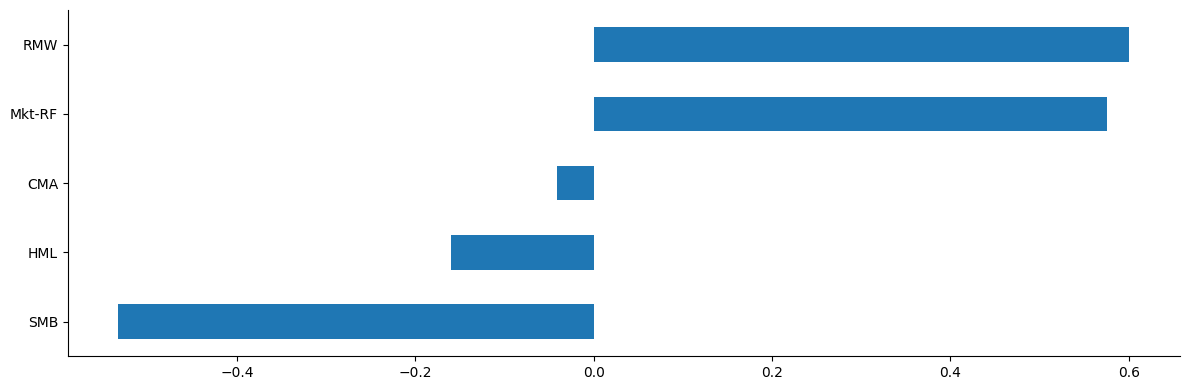

In [15]:
lambdas.mean().sort_values().plot.barh(figsize=(12, 4))
sns.despine()
plt.tight_layout();

In [16]:
t = lambdas.mean().div(lambdas.std())
t

Mkt-RF    0.123793
SMB      -0.074678
HML      -0.034542
RMW       0.121427
CMA      -0.006180
dtype: float64

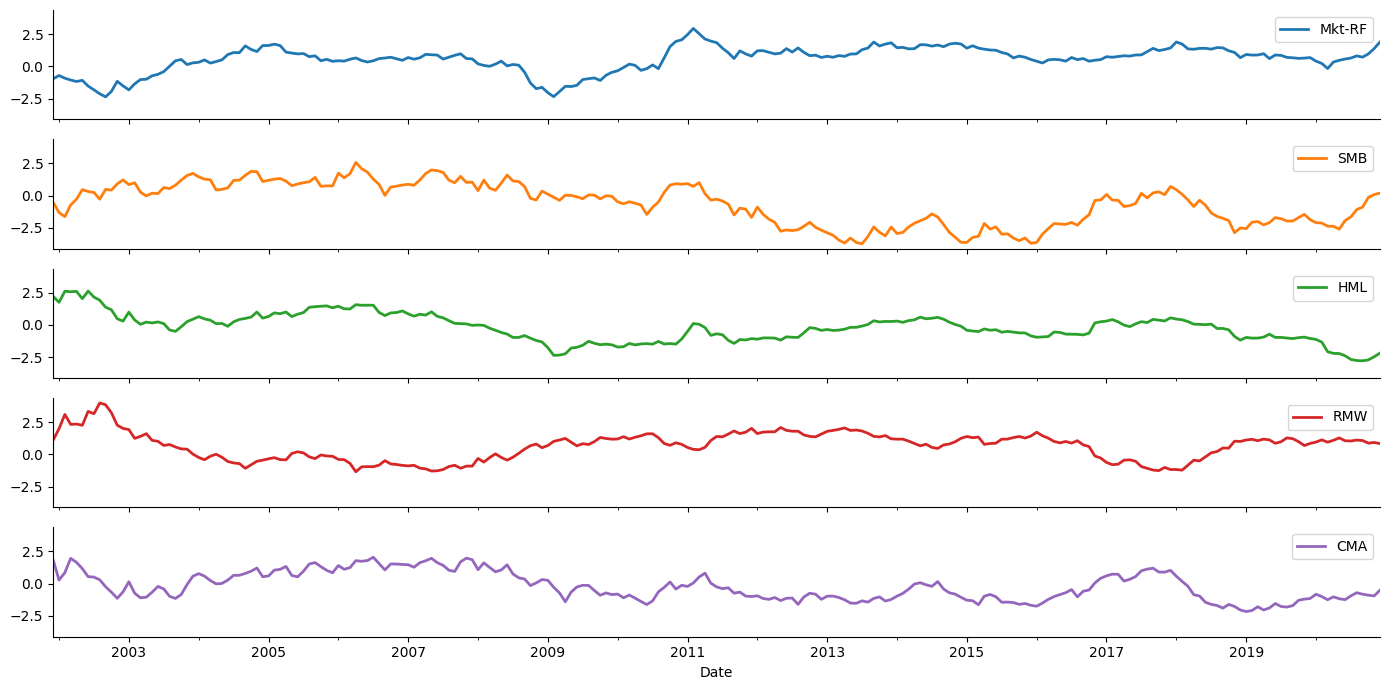

In [20]:
windows = 24  # months
lambdas.rolling(windows).mean().dropna().plot(lw=2,
                                              figsize=(14, 7),
                                              subplots=True,
                                              sharey=True)
sns.despine()
plt.tight_layout()

In [21]:
mod = LinearFactorModel(portfolios=ff_portfolio_data,
                        factors=ff_factor_data)
res = mod.fit()
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 17   R-squared:                      0.6827
No. Factors:                          5   J-statistic:                    12.912
No. Observations:                   252   P-value                         0.3755
Date:                  Mon, Jun 19 2023   Distribution:                 chi2(12)
Time:                          08:31:15                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.5760     0.3016     1.9101     0.0561     -0.0151      1.1670
SMB           -0.5332     0.5276    

In [22]:
print(res.full_summary)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 17   R-squared:                      0.6827
No. Factors:                          5   J-statistic:                    12.912
No. Observations:                   252   P-value                         0.3755
Date:                  Mon, Jun 19 2023   Distribution:                 chi2(12)
Time:                          08:31:15                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.5760     0.3016     1.9101     0.0561     -0.0151      1.1670
SMB           -0.5332     0.5276    